# Practica 2

In [1]:
import nltk
import numpy as np
from tqdm import tqdm
from unidecode import unidecode
from matplotlib import pyplot as plt
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [2]:
with open('corpusML.txt', 'r') as f:
    corpus = f.readlines()

In [3]:
corpus = [unidecode(line.lower()) for line in corpus]

In [4]:
corpus[0:2]

['comence a trabajar y me pegaron, me maltrataron con chicote \n',
 'mis patrones me pegaron porque no me queria apurar, porque era flojo \n']

### 1, 2) Limpiar corpus y agregar simbolos de inicio y fin

* Se limpia el corpus mediante el algoritmo de Porter para el lenguaje español. 
* A cada oracion del corpus, se le agrega el simbolo de inicio y fin. 
* Se crea el alfabeto $\Sigma$ del corpus donde se almacenen unicamente los tipos 

In [5]:
stemmer = SnowballStemmer("spanish")
stems = []                                              # Lista de stems por cada oracion
cleanedCorpus = []                                      # Corpus procesado con stemming
Sigma = []                                              # Alfabeto del corpus (tipos)               

for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)               # Obtener lista tokens
    for tk in tokens:   
        if tk.isalpha():                                # Validar token como caracter del alfabeto                                
            stem = stemmer.stem(tk)                     # Aplicar algotimo de stemming
            stems.append(stem)                          # Agregarlo a la lista de stems 
            if stem not in Sigma:                       # Agregar stem al alfabeto
                Sigma.append(stem)
    s = '<BOS> ' + ' '.join(stems) + ' <EOS>'           # Agregar simbolos de inicio y fin
    cleanedCorpus.append(s)                             # Agregar oracion procesada a la lista del corpus limpio                               
    stems.clear()

# Agregar simbolos de inicio y fin al alfabeto
Sigma.append('<BOS>')
Sigma.append('<EOS>')

In [6]:
cleanedCorpus[:3]

['<BOS> comenc a trabaj y me peg me maltrat con chicot <EOS>',
 '<BOS> mis patron me peg porqu no me queri apur porqu era floj <EOS>',
 '<BOS> por eso me habi peg <EOS>']

In [7]:
Sigma[-10:]

['cab',
 'bebecit',
 'tabiqu',
 'calent',
 'pajuel',
 'vapor',
 'quemart',
 'cai',
 '<BOS>',
 '<EOS>']

### 3) Obtener los bigramas

In [8]:
# Funcion para obtener los bigramas de una secuencia de caracteres
def bigrams(sequence):
    s = sequence.split()
    return [(wi, wj) for wi, wj in zip(s[:-1], s[1:])]

In [9]:
# Obtener los bigramas del corpus limpio
sentence_bigrams = [bigrams(s) for s in cleanedCorpus]

In [10]:
# Bigramas de la primera oracion
sentence_bigrams[0]

[('<BOS>', 'comenc'),
 ('comenc', 'a'),
 ('a', 'trabaj'),
 ('trabaj', 'y'),
 ('y', 'me'),
 ('me', 'peg'),
 ('peg', 'me'),
 ('me', 'maltrat'),
 ('maltrat', 'con'),
 ('con', 'chicot'),
 ('chicot', '<EOS>')]

In [11]:
# Bigramas de todo el corpus
corpus_bigrams = [bigram for sentence in sentence_bigrams for bigram in sentence]

In [12]:
corpus_bigrams[0:11]

[('<BOS>', 'comenc'),
 ('comenc', 'a'),
 ('a', 'trabaj'),
 ('trabaj', 'y'),
 ('y', 'me'),
 ('me', 'peg'),
 ('peg', 'me'),
 ('me', 'maltrat'),
 ('maltrat', 'con'),
 ('con', 'chicot'),
 ('chicot', '<EOS>')]

In [13]:
# Obtener los vectores one hot de cada palabra en el corpus
oneHotMatrix = np.identity(len(Sigma))

In [14]:
word2oneHot = {}        # Entrada: palabra del alfabeto, Salida: vector one hot
word2number = {}        # Entrada: palabra del alfabeto, Salida: indice en la lista del alfabeto
oneHot2word = {}        # Entrada: vector one hot (caracteres), Salida: palabra del alfabeto

for i, (word, vector) in enumerate(zip(Sigma, oneHotMatrix)):
    word2oneHot[word] = vector
    word2number[word] = i
    oneHot2word[np.where(vector==1)[0][0]] = word

In [15]:
word2oneHot['<EOS>']

array([0., 0., 0., ..., 0., 0., 1.])

In [16]:
word2number['<EOS>']

1215

### 4) Entrenar la red neuronal con los bigramas

Dados los bigramas del corpus $(w_i, w_j)$, la red neuronal word2vec es entrenada tomando como entrada y salida a la representacion vectorial *one hot encoded* de la palabra $w_i$ y la palabra $w_j$ respectivamente.

Los vectores de entrada tienen una dimension $x\in\mathbb{R}^{|\Sigma|}$ , que es el tamaño del alfabeto que obtuvimos a partir de los tipos del corpus.

En cuanto a la dimension de la primera capa (embedding), sera de 300 unidades neuronales por lo que la matriz de pesos tiene una dimension $U\in\mathbb{R}^{300x|\Sigma|}$.

Las dimensiones de la matriz de pesos de la segunda capa son de $W\in\mathbb{R}^{|\Sigma|x300}$.

#### Feed forward

**Capa 1**

La salida de la i-ésima neurona de la primera capa se calcula como: 

$h_i = \sum_{j=1}^{N}U_{ij}x_j$

Tambien se puede expresar de forma más general como el producto punto:

$h = U \cdot x$

$h = U_{\cdot,i}$

Este vector tiene una dimension $h\in\mathbb{R}^{300}$, por lo que realizar el producto punto entre la matriz de pesos $U$ y el vector one hot encoded $x$ que representa a la palabra $w_i$ es equivalente a seleccionar la columna i-ésima de $U$. 

**Capa 2**

La salida de la segunda capa se calcula como:

$a = W\cdot{h}$ 

$a = W_{i,\cdot}$

y tiene una dimension de $a\in\mathbb{R}^{|\Sigma|}$, lo cual es equivalente a seleccionar la fila i-ésima de la matriz $W$.

**Salida**

La funcion de activacion a la salida de esta ultima capa es la funcion *softmax* en la cual se calcula la probabilidad de que la palabra $w_k$ donde $k=1,...,|\Sigma|$ , aparesca despues de la palabra de entrada $w_i$, lo cual se expresa como:

$p(w_k|w_i) = \frac{e^{W\cdot{h}}}{\sum_{m}^{|\Sigma|}e^{W\cdot{h}}}$

In [88]:
d = 300                       # Dimension del embedding
N = len(Sigma)                # Tamaño del alfabeto
                            
U = np.random.randn(d, N)/np.sqrt(d+N)     # Matriz de embedding 
W = np.random.randn(N, d)/np.sqrt(d+N)     # Matriz de pesos capa 2

In [52]:
def softmax(x):
    x = x - np.max(x, keepdims=True)
    return np.divide(x, np.sum(x, axis=0, keepdims=True))

In [53]:
def predict(x):
    h = np.dot(U, x)
    a = np.dot(W, h)
    return softmax(a)

In [118]:
def fit(bigrams, lr, epochs):
    global U, W
    lossWi = []
    loss = []
    for epoch in range(epochs):
        for k, (wi, wj) in enumerate(bigrams):
            x = word2oneHot[wi]
            y = word2oneHot[wj]
            # Feedforward
            h = np.dot(U, x)
            a = np.dot(W, h)
            # Calcular error
            error = softmax(a) - y
            # -----------------------------
            lossWi.append(np.sum(y*np.log(softmax(a)+0.001), keepdims=True))
            if k == len(bigrams)-1:
                loss.append(-np.sum(np.array(lossWi)))
                lossWi.clear()
                print('EPOCH ({}) = {}'.format(epoch+1, loss[epoch]))
            # -----------------------------
            # Backpropragation
            W[np.where(y==1)[0][0],:] -= lr*error[np.where(y==1)[0][0]]*h
            #W -= lr*np.dot(error.reshape(-1,1), h.reshape(1,-1))
            delta = np.dot(W.T, error)
            U[:,np.where(x==1)[0][0]] -= lr*delta
            
    return loss

In [119]:
U = np.random.randn(d, N)/np.sqrt(d+N)     # Matriz de embedding 
W = np.random.randn(N, d)/np.sqrt(d+N)     # Matriz de pesos capa 2
err = fit(corpus_bigrams, 0.03, 100)

EPOCH (1) = 79509.14365173002
EPOCH (2) = 79339.16702695756
EPOCH (3) = 79385.8357012668
EPOCH (4) = 79385.8410846405
EPOCH (5) = 79385.84111827283
EPOCH (6) = 79385.84111841819
EPOCH (7) = 79385.84111841883
EPOCH (8) = 79385.84111841884
EPOCH (9) = 79385.84111841884
EPOCH (10) = 79385.84111841884
EPOCH (11) = 79385.84111841884
EPOCH (12) = 79385.84111841884
EPOCH (13) = 79385.84111841884
EPOCH (14) = 79385.84111841884
EPOCH (15) = 79385.84111841884
EPOCH (16) = 79385.84111841884
EPOCH (17) = 79385.84111841884
EPOCH (18) = 79385.84111841884
EPOCH (19) = 79385.84111841884
EPOCH (20) = 79385.84111841884
EPOCH (21) = 79385.84111841884
EPOCH (22) = 79385.84111841884
EPOCH (23) = 79385.84111841884
EPOCH (24) = 79385.84111841884
EPOCH (25) = 79385.84111841884
EPOCH (26) = 79385.84111841884
EPOCH (27) = 79385.84111841884
EPOCH (28) = 79385.84111841884
EPOCH (29) = 79385.84111841884
EPOCH (30) = 79385.84111841884
EPOCH (31) = 79385.84111841884
EPOCH (32) = 79385.84111841884
EPOCH (33) = 79385.

/home/sjkdm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


EPOCH (38) = nan
EPOCH (39) = nan
EPOCH (40) = nan
EPOCH (41) = nan
EPOCH (42) = nan
EPOCH (43) = nan
EPOCH (44) = nan
EPOCH (45) = nan
EPOCH (46) = nan
EPOCH (47) = nan
EPOCH (48) = nan
EPOCH (49) = nan
EPOCH (50) = nan
EPOCH (51) = nan
EPOCH (52) = nan
EPOCH (53) = nan
EPOCH (54) = nan
EPOCH (55) = nan
EPOCH (56) = nan
EPOCH (57) = nan
EPOCH (58) = nan
EPOCH (59) = nan
EPOCH (60) = nan
EPOCH (61) = nan
EPOCH (62) = nan
EPOCH (63) = nan
EPOCH (64) = nan
EPOCH (65) = nan
EPOCH (66) = nan
EPOCH (67) = nan
EPOCH (68) = nan
EPOCH (69) = nan
EPOCH (70) = nan
EPOCH (71) = nan
EPOCH (72) = nan
EPOCH (73) = nan
EPOCH (74) = nan
EPOCH (75) = nan
EPOCH (76) = nan
EPOCH (77) = nan
EPOCH (78) = nan
EPOCH (79) = nan
EPOCH (80) = nan
EPOCH (81) = nan
EPOCH (82) = nan
EPOCH (83) = nan
EPOCH (84) = nan
EPOCH (85) = nan
EPOCH (86) = nan
EPOCH (87) = nan
EPOCH (88) = nan
EPOCH (89) = nan
EPOCH (90) = nan
EPOCH (91) = nan
EPOCH (92) = nan
EPOCH (93) = nan
EPOCH (94) = nan
EPOCH (95) = nan
EPOCH (96) = n

In [115]:
# Prueba
#wordVector = word2oneHot[stemmer.stem('caballo')]
wordVector = word2oneHot['el']
pred = predict(wordVector)
print(pred)
print(pred.shape)
print(np.sum(pred))

indice = np.argmax(pred)
print(indice)

print('prediccion => ', oneHot2word[indice])

print(pred[indice])

[0.00084766 0.00064705 0.00067487 ... 0.00081128 0.00084766 0.00014396]
(1216,)
0.9999999999999999
340
prediccion =>  mientr
0.0008649290866845483


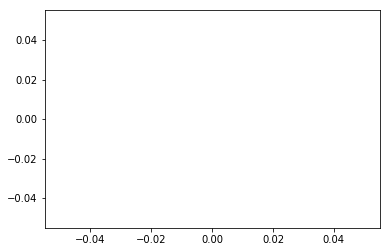

In [280]:
plt.plot(err)
plt.show()

In [240]:
err[0][:]

(1, 73923.71882300425)

### 5) Obtener las matrices $A$ y $\Pi$

In [278]:
# Para cada palabra del alfabeto, predecir el vector de probabilidades
# y agruparlos por columna para hacer la matriz A

A = []

for wj in Sigma[:-2]:
    aj = predict(word2oneHot[wj])
    A.append(list(aj))
    
A = np.matrix(A).T

In [279]:
A.shape

(1216, 1214)

In [280]:
# El vector de inicio se obtiene al predecir la distribucion
# para el simbolo <BOS>
Pi = predict(word2oneHot['<BOS>'])

### 6) Calcular la propabilidad de las siguientes oraciones

Se calcularan usando la propiedad de Markov que establece que:

$p(x_1,...,x_n)=\prod_{i=1}^{n}p(w_{i}|w_{i-1})$

1) Nos ba;amos con agua caliente

$p(caliente|agua)p(agua|con)p(con|banamos)p(banamos|nos)p(nos|bos)$

In [299]:
#s = 'Nos banamos con agua caliente'.split()
s = '<BOS> pascuala ordenaba las vacas'.split()
s[1:] = [stemmer.stem(word.lower()) for word in s[1:]]

In [300]:
#j = word2number['las']
#i = word2number['vacas']

#A[i,j]

In [301]:
#Pi[word2number['pues']]

In [302]:
p = 1

for wi, wj in zip(s[:-1], s[1:]):
    if wi == '<BOS>':
        p *= Pi[word2number[wj]]
    else:
        i = word2number[wj]
        j = word2number[wi]
        p *= A[i,j]
        
print('p(s) = ', p)

p(s) =  2.425589910422211e-19


In [283]:
from nltk.stem import PorterStemmer

In [285]:
po = PorterStemmer()

In [286]:
po.stem('caliente')

'calient'